# Library Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
import keras
from keras import regularizers

In [ ]:
import os
import re
import shutil
import string
import numpy as np
import seaborn as sns
import pickle

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Acquiring the Dataset

In [ ]:
# accessing the imdb dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

datasetDir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84140032/84125825 [==============================] - 9s 0us/step


In [ ]:
# list of contents of the dataset main directory
os.listdir(datasetDir)

['test', 'imdb.vocab', 'train', 'imdbEr.txt', 'README']

In [ ]:
# exploring the training section
trainDir = os.path.join(datasetDir, 'train')
os.listdir(trainDir)

['labeledBow.feat',
 'unsup',
 'urls_pos.txt',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt']

In [ ]:
# positive reviews
os.listdir(os.path.join(trainDir, "pos"))[:10]

['3373_7.txt',
 '10013_7.txt',
 '6811_10.txt',
 '12302_7.txt',
 '11483_10.txt',
 '1918_9.txt',
 '9374_9.txt',
 '9401_10.txt',
 '1005_10.txt',
 '1131_7.txt']

In [ ]:
# opening a sample negative review
with open(os.path.join(os.path.join(trainDir, "neg"),
                       os.listdir(os.path.join(trainDir, "neg"))[80])) as f:
  print(f.read())

Loyalty to Peter Falk is all that kept me from giving this awful picture the (1) it deserved. (For that matter, loyalty to Mr. Falk was what kept me watching this film all the way from heads to tails.) Even if you forgive all the glaring errors, this was just plain the poorest excuse for a made-for-TV "Columbo" film ever. I'm glad I watched it on TV for free; would have hated to have coughed up the bucks for a print.


In [ ]:
# removing the unsup subdirectory
shutil.rmtree(os.path.join(trainDir, "unsup"))
os.listdir(trainDir)

['labeledBow.feat',
 'urls_pos.txt',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt']

# Data Partitioning

In [ ]:
# the dataset already has two partitions
# in the test and train subdirectories
# train will be partitioned into train and validation

# partition ratio - validation as a fraction of train whole
PARTITION_VAL = 0.2

In [ ]:
BATCH_SIZE = 128
SEED = 42

In [ ]:
# train partition 1 without preprocessing
rawTrain1 = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size = BATCH_SIZE, 
    validation_split = PARTITION_VAL, 
    subset = 'training', 
    seed =  SEED
    )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
# few samples of the training partition
for textBatch, labelBatch in rawTrain1.take(1):
  for i in range(20, 30):
    print("Review: ", textBatch.numpy()[i])
    print("Label: ", labelBatch.numpy()[i])
print("Where")
print("Label 0 =", rawTrain1.class_names[0])
print("Label 1 =", rawTrain1.class_names[1])

Review:  b"When I heard the plot for this movie I simply had to see it, I mean whole cities being wiped out by killer tomatoes! Sadly the title is about as funny as it gets.<br /><br />Led by Detective Dick Mason, a special team of military and scientists (including Greg Colburn who never takes his SCUBA outfit off and Lt. Finletter who is never pictured without his parachute trailing behind) 'Attack Of The Killer Tomatoes' is a parody of B-Movies, in particular Japanese horror of the 1950's. The film begins with a standard sized tomato being discovered by a women washing up in her kitchen before we find ourselves in a middle of a crime scene as the tomato has supposedly murdered this lady, and let me tell you it doesn't get any saner as the film progresses! To be fair there are a couple of funny moments, for instance anytime the Japanese scientist Dr Nokitofa speaks his voice is dubbed over in an American accent, or when disguise expert Sam Smith infiltrates the tomatoes 'hey, can som

In [ ]:
# validation partition without preprocessing
rawVal = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size = BATCH_SIZE, 
    validation_split = PARTITION_VAL, 
    subset = 'validation', 
    seed = SEED
    )

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# train partition 1 without preprocessing
rawTrain2 = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size = BATCH_SIZE, 
    validation_split = PARTITION_VAL, 
    subset = 'training', 
    seed =  SEED
    )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
# testing partition without preprocessing
rawTest = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size = BATCH_SIZE,
    validation_split = PARTITION_VAL,
    subset = 'validation',
    seed = SEED
    )

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# joining training data from the two folders
# to get the final training data
rawTrain = rawTrain1.concatenate(rawTrain2)
rawTrain

<ConcatenateDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# few samples of the training partition
for textBatch, labelBatch in rawTrain.take(1):
  for i in range(20, 30):
    print("Review: ", textBatch.numpy()[i])
    print("Label: ", labelBatch.numpy()[i])
print("Where")
print("Label 0 =", rawTrain1.class_names[0])
print("Label 1 =", rawTrain1.class_names[1])

Review:  b'NOTHING (3+ outta 5 stars) Another weird premise from the director of the movie "Cube". This time around there are two main characters who find themselves and their home transported to a mysterious white void. There is literally NOTHING outside of their small two-story house. Intriguing to be sure, but I thought the comedic tone established for this movie from the get-go was extremely ill-conceived. There needs to be some humour, certainly... and I have no problem with the humour that was eventually derived from the plight of our two heroes (their final "showdown" was definitely a hoot)... but I really think the movie would have been a lot better off if it had stayed more rooted in reality in the beginning. After watching the movie I watched the "Making of" feature on the DVD and a short trailer at the end is almost totally devoid of the "sillier" comedic aspects... making it look like a completely different (and slightly better) movie. The last half hour of the movie is whe

# Data Preprocessing

In [ ]:
# removes the HTML tags and punctuation in the given text
def stripHTMLAndPunctuation(inputText):
  noHTML = tf.strings.regex_replace(tf.strings.lower(inputText), 
                                    "(<br />)|(</?p>)", ' ')
  return tf.strings.regex_replace(noHTML,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
# maximum vocab size
MAX_FEATURES = 10000

# length to text vector
SEQ_LEN = 250

In [ ]:
# layer to create vectors from raw text
vectorizeLayer = layers.TextVectorization(
    standardize = stripHTMLAndPunctuation,
    max_tokens = MAX_FEATURES,
    output_mode = 'int',
    output_sequence_length = SEQ_LEN)

In [ ]:
# adapting the layer to learn the vocab
vectorizeLayer.adapt(rawTrain.map(lambda x, y: x))

In [ ]:
pickle.dump({'config': vectorizeLayer.get_config(),
             'weights': vectorizeLayer.get_weights()}
            , open("/content/tv_layer.pkl", "wb"))

In [ ]:
# exploring the vocab
print(vectorizeLayer.get_vocabulary()[100: 200])
print('Vocabulary size: {}'.format(len(vectorizeLayer.get_vocabulary())))

['characters', 'after', 'think', 'watch', 'many', 'seen', 'two', 'character', 'being', 'never', 'love', 'acting', 'plot', 'did', 'where', 'best', 'know', 'little', 'show', 'life', 'ever', 'does', 'your', 'better', 'end', 'off', 'over', 'still', 'these', 'say', 'scene', 'man', 'here', 'why', 'while', 'scenes', 'such', 'something', 'go', 'through', 'should', 'im', 'those', 'back', 'real', 'watching', 'now', 'thing', 'didnt', 'doesnt', 'actors', 'years', 'though', 'another', 'before', 'funny', 'actually', 'nothing', 'makes', 'find', 'work', 'look', 'same', 'lot', 'going', 'every', 'new', 'few', 'old', 'again', 'us', 'part', 'director', 'cant', 'things', 'cast', 'thats', 'quite', 'want', 'pretty', 'around', 'seems', 'world', 'down', 'young', 'got', 'enough', 'fact', 'take', 'however', 'horror', 'give', 'both', 'big', 'thought', 'ive', 'may', 'between', 'own', 'long']
Vocabulary size: 10000


In [ ]:
# vectorizes the text
def vectorizeText(inputText, label):
  return vectorizeLayer(tf.expand_dims(inputText, -1)), label

In [ ]:
# explore effect of vectorization on a review
textBatch, labelBatch = next(iter(rawTrain))
print("Review:", textBatch[BATCH_SIZE // 2])
print("Label:", rawTrain1.class_names[labelBatch[BATCH_SIZE // 2]])
print("Vectorized review:", vectorizeText(textBatch[BATCH_SIZE // 2],
                                           labelBatch[BATCH_SIZE // 2]))

Review: tf.Tensor(b"While exploring some caves with his wife, a doctor is bitten by a bat which causes some alarming side effects...<br /><br />Occasionally creepy atmosphere and some decent (though under used) makeup effects don't save this B horror flick from being a sub-par tale of man-becomes-creature. The Bat People aka It Lives By Night suffers from its senseless story that's awkwardly plotted and lackluster in pacing. The plot never seems to go anywhere much and the movie never offers an explanation for what happens, or even a satisfying conclusion for it all. The cast is fairly mediocre in their performances.<br /><br />Still I give the film some points for its haunting theme song and nice filming locations. The makeup work of the late Stan Winston is pretty good too, but it doesn't get much of a showcase here. A missed opportunity for sure. <br /><br />Definitely one of the lesser man-creature flicks out there.<br /><br />* 1/2 out of ****", shape=(), dtype=string)
Label: neg


In [ ]:
# vectorizing the train, validation, and test data
trainData = rawTrain.map(vectorizeText)
valData = rawVal.map(vectorizeText)
testData = rawTest.map(vectorizeText)

# Caching for Speed

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
trainData = trainData.cache().prefetch(buffer_size = AUTOTUNE)
valData = valData.cache().prefetch(buffer_size = AUTOTUNE)
testData = testData.cache().prefetch(buffer_size = AUTOTUNE)

# LSTM Model

In [ ]:
# embedding layer output size
EMBEDDING_DIM = 64

In [ ]:
# model definition
modelLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim = MAX_FEATURES + 1,
        output_dim = EMBEDDING_DIM,
        mask_zero=True),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
    tf.keras.layers.LSTM(200),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 lstm (LSTM)                 (None, 200)               212000    
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 864,993
Trainable params: 864,993
Non-trainable params: 0
_________________________________________________________________


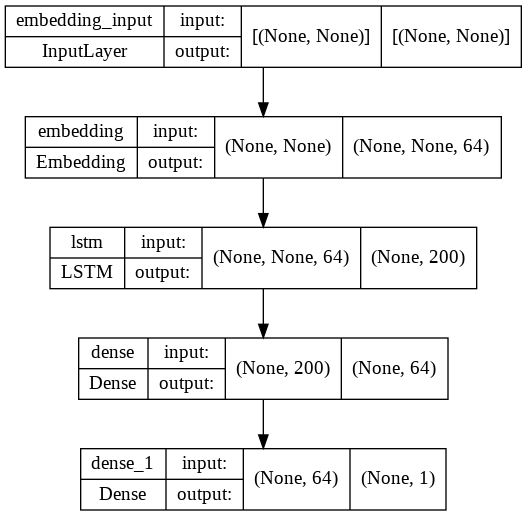

In [ ]:
keras.utils.vis_utils.plot_model(modelLSTM, show_shapes = True)

In [ ]:
modelLSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
EPOCHS_LSTM = 5

In [ ]:
# model training
history = modelLSTM.fit(
    trainData,
    validation_data = valData,
    epochs = EPOCHS_LSTM)

Epoch 1/5
314/314 [==============================] - 25s 52ms/step - loss: 0.5856 - accuracy: 0.6249 - val_loss: 0.4133 - val_accuracy: 0.8144
Epoch 2/5
314/314 [==============================] - 9s 27ms/step - loss: 0.3235 - accuracy: 0.8661 - val_loss: 0.3386 - val_accuracy: 0.8646
Epoch 3/5
314/314 [==============================] - 9s 27ms/step - loss: 0.2530 - accuracy: 0.9018 - val_loss: 0.3342 - val_accuracy: 0.8728
Epoch 4/5
314/314 [==============================] - 9s 27ms/step - loss: 0.2223 - accuracy: 0.9159 - val_loss: 0.3208 - val_accuracy: 0.8768
Epoch 5/5
314/314 [==============================] - 9s 27ms/step - loss: 0.2032 - accuracy: 0.9255 - val_loss: 0.3291 - val_accuracy: 0.8778


In [ ]:
# evaluation on test dataset
testLoss, testAccuracy = modelLSTM.evaluate(testData)
!mkdir -p modelLSTM
modelLSTM.save('/content/modelLSTM/')

print("Loss: ", testLoss)
print("Accuracy: ", testAccuracy)

40/40 [==============================] - 1s 30ms/step - loss: 0.3177 - accuracy: 0.8808


INFO:tensorflow:Assets written to: /content/modelLSTM/assets


INFO:tensorflow:Assets written to: /content/modelLSTM/assets


Loss:  0.3177296817302704
Accuracy:  0.8808000087738037


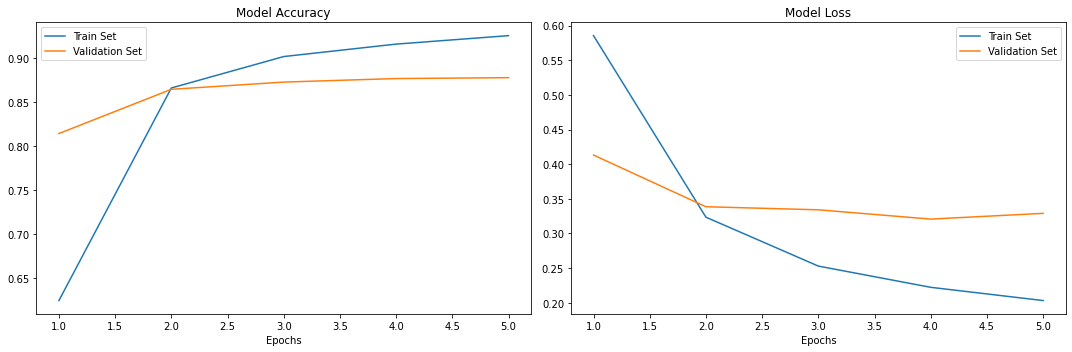

In [ ]:
# plotting training loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, EPOCHS_LSTM + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
yPred = np.array(modelLSTM.predict(testData) >= 0)

In [ ]:
yPred

array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [False]])

In [ ]:
testData

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
yActual = np.concatenate([y for x, y in testData], axis=0)

In [ ]:
yActual.shape

(5000,)

In [ ]:
yPredNumeric = np.reshape(1 * yPred, (yPred.shape[0],))
print(yPredNumeric, yPredNumeric.shape, sep = "\n")

[1 0 0 ... 1 1 0]
(5000,)


In [ ]:
# model evaluation
print("accuracy of LSTM based model = {}".format(accuracy_score(yActual, yPredNumeric)))
print(classification_report(yActual, yPredNumeric))

accuracy of LSTM based model = 0.8778
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      2462
           1       0.86      0.91      0.88      2538

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



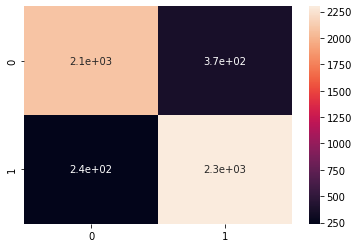

In [ ]:
# confusion matrix
cfm = confusion_matrix(yActual, yPredNumeric)
sns.heatmap(cfm, annot = True)

In [ ]:
tn, fp, fn, tp = confusion_matrix(yActual, yPredNumeric).ravel()
print("specificity =", tn / (tn + fp))

specificity = 0.8484971567831032


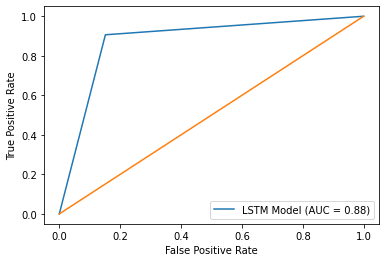

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(yActual, yPredNumeric)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='LSTM Model')
display.plot()
plt.plot(fpr, fpr)
plt.show()

# CNN Based Model

In [ ]:
LAMBDA = 0.0001

In [ ]:
# model definition
modelCNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim = MAX_FEATURES + 1,
        output_dim = EMBEDDING_DIM,
        mask_zero=True),
    tf.keras.layers.Conv1D(filters = 64, 
                           kernel_regularizer=regularizers.l2(LAMBDA),
                           kernel_initializer='he_uniform',
                           kernel_size = 3,
                           activation = "relu"),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 2,
                           kernel_regularizer=regularizers.l2(LAMBDA),
                           kernel_initializer='he_uniform',
                           activation = "relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(LAMBDA),
                          kernel_initializer='he_uniform',
                          activation = "relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
modelCNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640064    
                                                                 
 conv1d (Conv1D)             (None, None, 64)          12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          4128      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                               

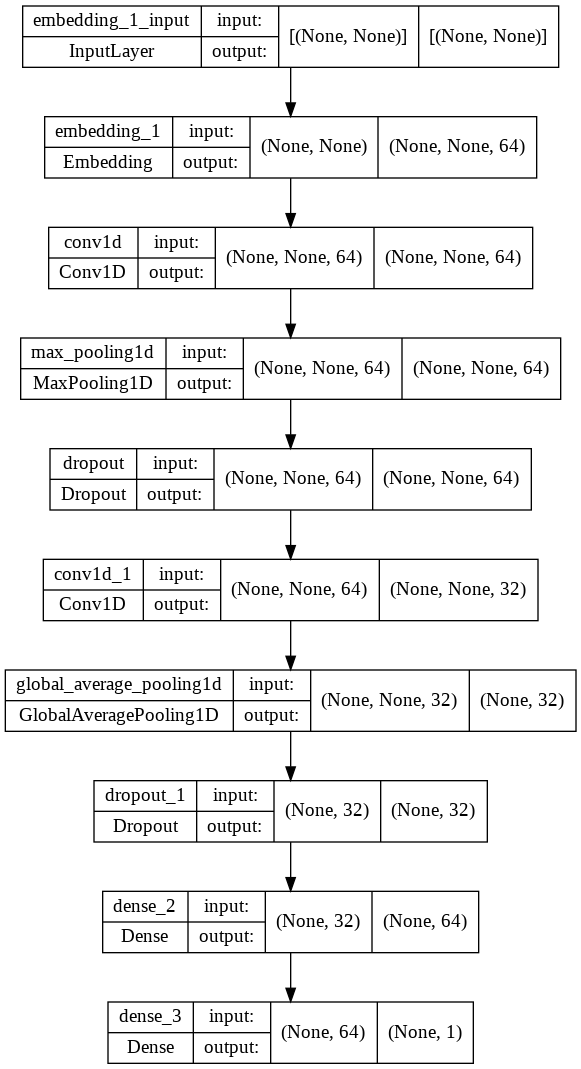

In [ ]:
keras.utils.vis_utils.plot_model(modelCNN, show_shapes = True)

In [ ]:
modelCNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
EPOCHS_CNN = 8

In [ ]:
# model training
history = modelCNN.fit(
    trainData,
    validation_data = valData,
    epochs = EPOCHS_CNN)

Epoch 1/8
314/314 [==============================] - 10s 9ms/step - loss: 0.7194 - accuracy: 0.5019 - val_loss: 0.7047 - val_accuracy: 0.4924
Epoch 2/8
314/314 [==============================] - 3s 8ms/step - loss: 0.6084 - accuracy: 0.6103 - val_loss: 0.4522 - val_accuracy: 0.8054
Epoch 3/8
314/314 [==============================] - 2s 7ms/step - loss: 0.4058 - accuracy: 0.8292 - val_loss: 0.3501 - val_accuracy: 0.8542
Epoch 4/8
314/314 [==============================] - 2s 7ms/step - loss: 0.3374 - accuracy: 0.8680 - val_loss: 0.3278 - val_accuracy: 0.8634
Epoch 5/8
314/314 [==============================] - 2s 8ms/step - loss: 0.3064 - accuracy: 0.8846 - val_loss: 0.3178 - val_accuracy: 0.8730
Epoch 6/8
314/314 [==============================] - 2s 7ms/step - loss: 0.2844 - accuracy: 0.8953 - val_loss: 0.3147 - val_accuracy: 0.8762
Epoch 7/8
314/314 [==============================] - 2s 7ms/step - loss: 0.2689 - accuracy: 0.9031 - val_loss: 0.3140 - val_accuracy: 0.8792
Epoch 8/8
31

In [ ]:
# evaluation on test dataset
testLoss, testAccuracy = modelCNN.evaluate(testData)
!mkdir -p modelCNN
modelCNN.save('/content/modelCNN/')

print("Loss: ", testLoss)
print("Accuracy: ", testAccuracy)

40/40 [==============================] - 0s 4ms/step - loss: 0.3024 - accuracy: 0.8840
INFO:tensorflow:Assets written to: /content/modelCNN/assets


INFO:tensorflow:Assets written to: /content/modelCNN/assets


Loss:  0.3023744225502014
Accuracy:  0.8840000033378601


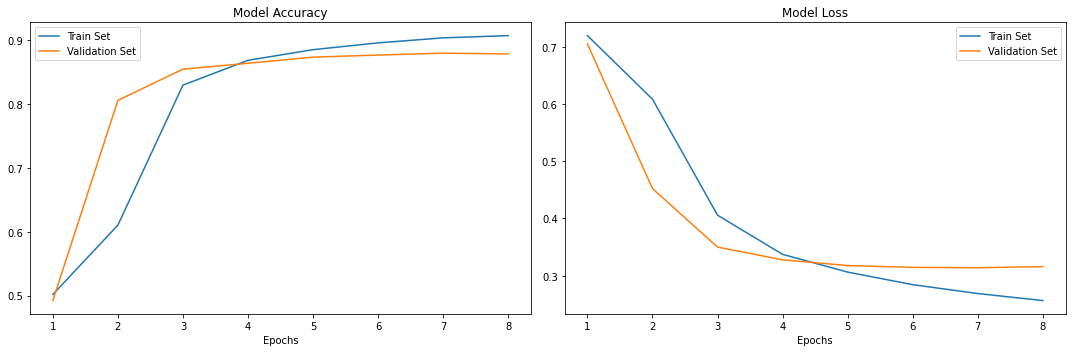

In [ ]:
# plotting training loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, EPOCHS_CNN + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
yPred = np.array(modelCNN.predict(testData) >= 0)

In [ ]:
yActual = np.concatenate([y for x, y in testData], axis=0)

In [ ]:
yPredNumeric = np.reshape(1 * yPred, (yPred.shape[0],))
print(yPredNumeric, yPredNumeric.shape, sep = "\n")

[1 0 0 ... 1 1 0]
(5000,)


In [ ]:
# model evaluation
print("accuracy of CNN based model = {}".format(accuracy_score(yActual, yPredNumeric)))
print(classification_report(yActual, yPredNumeric))

accuracy of CNN based model = 0.8892
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2462
           1       0.90      0.88      0.89      2538

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



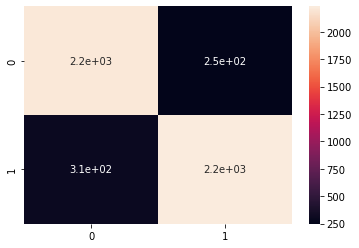

In [ ]:
# confusion matrix
cfm = confusion_matrix(yActual, yPredNumeric)
sns.heatmap(cfm, annot = True)

In [ ]:
tn, fp, fn, tp = confusion_matrix(yActual, yPredNumeric).ravel()
print("specificity =", tn / (tn + fp))

specificity = 0.8992688870836718


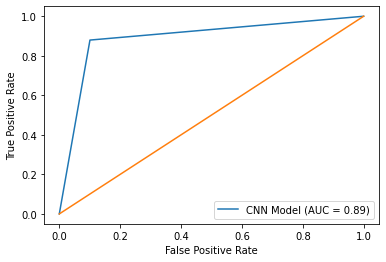

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(yActual, yPredNumeric)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='CNN Model')
display.plot()
plt.plot(fpr, fpr)
plt.show()

# LSTM-CNN Based Model

In [ ]:
# model definition
modelCombine = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim = MAX_FEATURES + 1,
        output_dim = EMBEDDING_DIM,
        mask_zero=True),
    tf.keras.layers.LSTM(200, 
                         kernel_regularizer=regularizers.l2(LAMBDA),
                         return_sequences = True),
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, 
                           kernel_regularizer=regularizers.l2(LAMBDA),
                           kernel_initializer='he_uniform',
                           activation = "relu"),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, 
                           kernel_regularizer=regularizers.l2(LAMBDA),
                           kernel_initializer='he_uniform',
                           activation = "relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, 
                          kernel_regularizer=regularizers.l2(LAMBDA),
                          kernel_initializer='he_uniform',
                          activation = "relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
modelCombine.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640064    
                                                                 
 lstm_1 (LSTM)               (None, None, 200)         212000    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          38464     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          4128      
                                                      

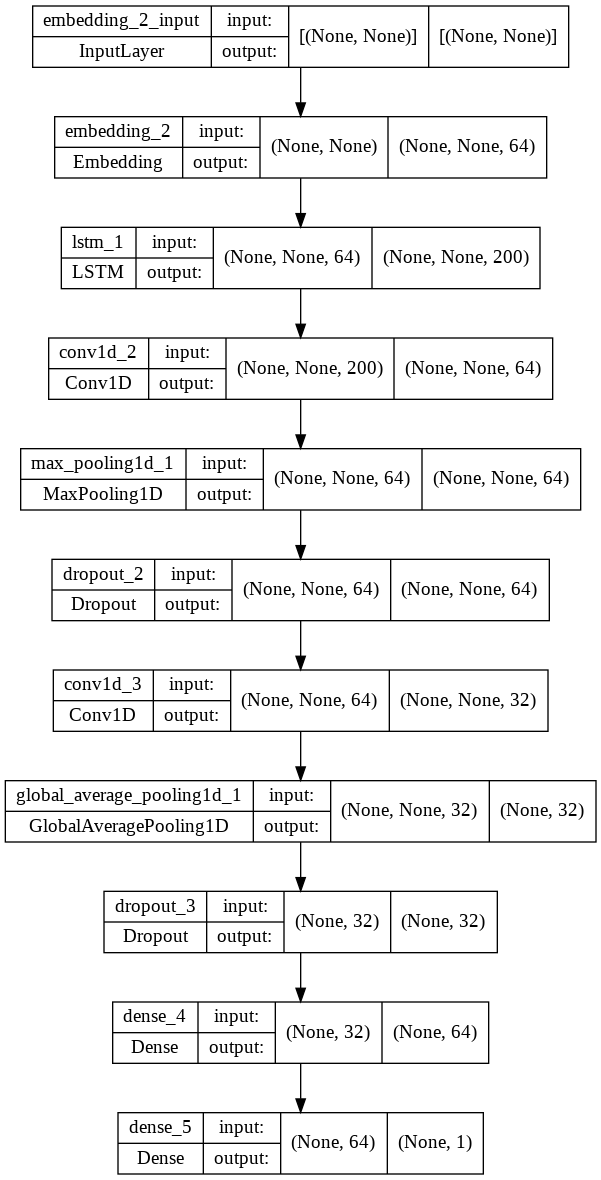

In [ ]:
keras.utils.vis_utils.plot_model(modelCombine, show_shapes = True)

In [ ]:
modelCombine.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
EPOCHS_Combine = 6

In [ ]:
# model training
history = modelCombine.fit(
    trainData,
    validation_data = valData,
    epochs = EPOCHS_Combine)

Epoch 1/6
314/314 [==============================] - 16s 37ms/step - loss: 0.6266 - accuracy: 0.6211 - val_loss: 0.4622 - val_accuracy: 0.8064
Epoch 2/6
314/314 [==============================] - 10s 33ms/step - loss: 0.3774 - accuracy: 0.8529 - val_loss: 0.3983 - val_accuracy: 0.8570
Epoch 3/6
314/314 [==============================] - 10s 33ms/step - loss: 0.3091 - accuracy: 0.8867 - val_loss: 0.3784 - val_accuracy: 0.8626
Epoch 4/6
314/314 [==============================] - 10s 33ms/step - loss: 0.2767 - accuracy: 0.9013 - val_loss: 0.4485 - val_accuracy: 0.8622
Epoch 5/6
314/314 [==============================] - 10s 33ms/step - loss: 0.2557 - accuracy: 0.9107 - val_loss: 0.5259 - val_accuracy: 0.8626
Epoch 6/6
314/314 [==============================] - 10s 33ms/step - loss: 0.2388 - accuracy: 0.9179 - val_loss: 0.5162 - val_accuracy: 0.8592


In [ ]:
# evaluation on test dataset
testLoss, testAccuracy = modelCombine.evaluate(testData)
!mkdir -p modelCombine
modelCombine.save('/content/modelCombine/')

print("Loss: ", testLoss)
print("Accuracy: ", testAccuracy)

40/40 [==============================] - 1s 15ms/step - loss: 0.4751 - accuracy: 0.8644


INFO:tensorflow:Assets written to: /content/modelCombine/assets


INFO:tensorflow:Assets written to: /content/modelCombine/assets


Loss:  0.47508788108825684
Accuracy:  0.8644000291824341


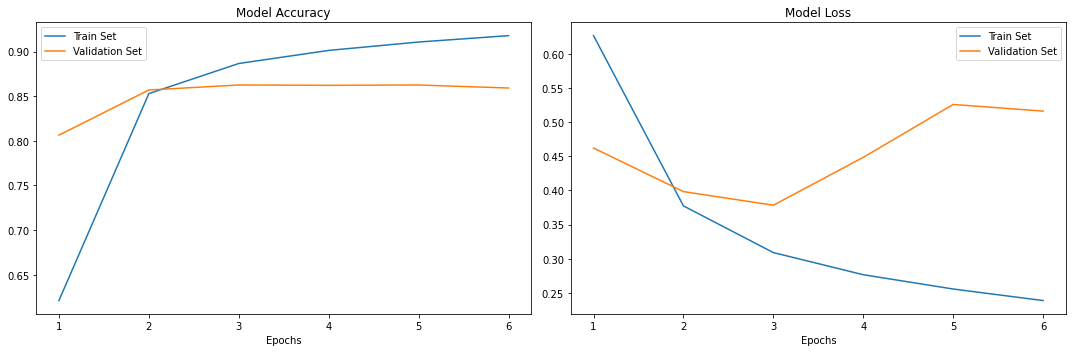

In [ ]:
# plotting training loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, EPOCHS_Combine + 1)

plt.figure(figsize=(15,5))
#plt.axis([0, 7, 0, 1])

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')
#plt.axis([0, 7, 0.5, 1])

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
#plt.axis([0, 7, 0, 1])
plt.show()

In [ ]:
yPred = np.array(modelCombine.predict(testData) >= 0)

In [ ]:
yActual = np.concatenate([y for x, y in testData], axis=0)

In [ ]:
yPredNumeric = np.reshape(1 * yPred, (yPred.shape[0],))
print(yPredNumeric, yPredNumeric.shape, sep = "\n")

[1 0 0 ... 1 1 0]
(5000,)


In [ ]:
# model evaluation
print("accuracy of LSTM-CNN based model = {}".format(accuracy_score(yActual, yPredNumeric)))
print(classification_report(yActual, yPredNumeric))

accuracy of LSTM-CNN based model = 0.8644
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2462
           1       0.86      0.87      0.87      2538

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



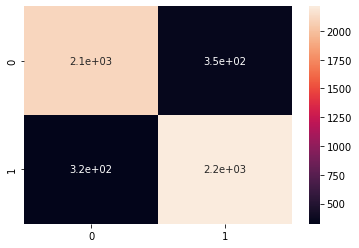

In [ ]:
# confusion matrix
cfm = confusion_matrix(yActual, yPredNumeric)
sns.heatmap(cfm, annot = True)

In [ ]:
tn, fp, fn, tp = confusion_matrix(yActual, yPredNumeric).ravel()
print("specificity =", tn / (tn + fp))

specificity = 0.8566206336311941


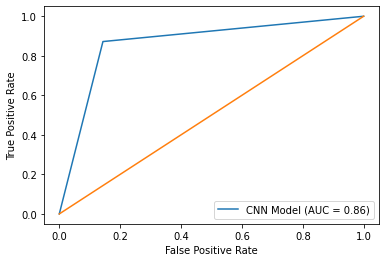

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(yActual, yPredNumeric)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='CNN Model')
display.plot()
plt.plot(fpr, fpr)
plt.show()

# GUI & Deployment

In [ ]:
# Currently Under Development...

In [ ]:
# Installing Streamlit for UI/UX and ngrok for deployment
!pip install -q streamlit
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

     |████████████████████████████████| 10.1 MB 31.6 MB/s 
     |████████████████████████████████| 76 kB 7.1 MB/s 
     |████████████████████████████████| 164 kB 81.6 MB/s 
     |████████████████████████████████| 4.3 MB 66.0 MB/s 
     |████████████████████████████████| 111 kB 77.8 MB/s 
     |████████████████████████████████| 181 kB 56.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 131 kB 74.6 MB/s 
     |████████████████████████████████| 130 kB 76.8 MB/s 
     |████████████████████████████████| 428 kB 68.0 MB/s 
     |████████████████████████████████| 793 kB 66.8 MB/s 
     |████████████████████████████████| 381 kB 73.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 

In [ ]:
##########################################################

In [ ]:
# app.py
%%writefile app.py
import streamlit as st
import array
import numpy as np
import time
import tensorflow as tf
import pickle
import re
import string

def stripHTMLAndPunctuation(inputText):
  noHTML = tf.strings.regex_replace(tf.strings.lower(inputText), 
                                    "(<br />)|(</?p>)", ' ')
  return tf.strings.regex_replace(noHTML,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


if 'line_counter' not in st.session_state:
    st.session_state.line_counter = 0
if 'list_x' not in st.session_state:
    st.session_state.list_x = []

st.set_page_config(
    page_title = "INFORMATION RETRIEVAL ASSIGNMENT", 
    page_icon = None, 
    layout = "centered", 
    initial_sidebar_state = "auto", 
    menu_items = None)

st.sidebar.subheader('Team Members')
st.sidebar.text('Abhirath Anupam Joshi - 2019A7PS1136P')
st.sidebar.text('Amulya Gupta - 2019D2TS1278P')
st.sidebar.text('Yash Gupta - 2019A7PS1138P')

st.header('Sentiment Analysis')

c1 = st.container()
c2 = st.container()
c3 = st.container()

modelCNN = tf.keras.models.load_model('/content/modelCNN')
modelLSTM = tf.keras.models.load_model('/content/modelLSTM')
modelCombine = tf.keras.models.load_model('/content/modelCombine')

from_disk = pickle.load(open("/content/tv_layer.pkl", "rb"))
new_v = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
new_v.set_weights(from_disk['weights'])

result_CNN = None
result_LSTM = None
result_Combine = None

with c3:
    view_analysis_history = st.expander('View Analysis History')

def create_log(line_count, review, result1, result2, result3):
    st.session_state.list_x.append((line_count, review, result1, result2, result3))
    for count, re, LSTM_result, CNN_result, Combine_result in st.session_state.list_x:
        view_analysis_history.write(f"{count}. {re}")
        view_analysis_history.write(f"LSTM Prediction: {LSTM_result}")
        view_analysis_history.write(f"CNN Prediction: {CNN_result}")
        view_analysis_history.write(f"LSTM-CNN Prediction: {Combine_result}")

with c1:
    with st.form(key = 'review_input', clear_on_submit = False):
        input_review = st.text_input(label = 'Enter the Review: ')
        input_vector = new_v(tf.expand_dims(input_review, -1))
        submit_button = st.form_submit_button(label = 'Analyze Review')
        if submit_button:
            with st.spinner(text = 'Predicting...'):
                result_CNN = "Positive" if(modelCNN.predict(input_vector) >= 0) else "Negative"
                result_LSTM = "Positive" if(modelLSTM.predict(input_vector) >= 0) else "Negative"
                result_Combine = "Positive" if(modelCombine.predict(input_vector) >= 0) else "Negative"
            if len(st.session_state.list_x) == 0:
                st.session_state.line_counter += 1
                create_log(st.session_state.line_counter, input_review, result_LSTM, result_CNN, result_Combine)
            else:
                st.session_state.line_counter += 1
                create_log(st.session_state.line_counter, input_review, result_LSTM, result_CNN, result_Combine)

with c2:
    column1, column2, column3 = st.columns(3)
    column1.subheader("LSTM")
    column2.subheader("CNN")
    column3.subheader("LSTM-CNN")      

Overwriting app.py


In [ ]:
"""
from_disk = pickle.load(open("/content/tv_layer.pkl", "rb"))
new_v = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
new_v.set_weights(from_disk['weights'])
input_vector = new_v(tf.expand_dims("hello this is a bad movie", -1))
modelCNN.predict(input_vector)[0][0]
"""

'\nfrom_disk = pickle.load(open("/content/tv_layer.pkl", "rb"))\nnew_v = tf.keras.layers.TextVectorization.from_config(from_disk[\'config\'])\nnew_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))\nnew_v.set_weights(from_disk[\'weights\'])\ninput_vector = new_v(tf.expand_dims("hello this is a bad movie", -1))\nmodelCNN.predict(input_vector)[0][0]\n'

In [ ]:
# Auth Token
!./ngrok authtoken 22Y8b0BGDmC8kdsmAO0zULTo076_5iEDVcctcRxrCBiMyHTCY

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://8ec3-35-240-161-129.ngrok.io


In [ ]:
!streamlit run /content/app.py

2022-04-29 11:56:55.981 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.240.161.129:8501

2022-04-29 11:57:14.673744: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-04-29 11:57:15.767507: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-29 11:57:16.208242: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-29 11:57:16.453107: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _out